# Extracting and Analyzing Treasury data using FRED API.

- Extract data.
- Data cleansing, Data wrangling.
- Data Analysis - PCA, tSVD.
- Visualize results.

## Install all required packages

In [1]:
%%capture
pip install -r fred_requirements.txt

## Import modules

In [2]:
## Import Utility module
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime

## Import FRED API python module
from full_fred.fred import Fred

## Import sklearn module for Dimensionality reduction functionality
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA, TruncatedSVD

# Step 1: Query and retrieve the following data series from online macroeconomic database FRED using their API (https://fred.stlouisfed.org/):

_ | Data series | FRED Ticker
 
1 | US 1Y Treasury | GS1

2 | US 2Y Treasury | GS2

3 | US 3Y Treasury | GS3

4 | US 5Y Treasury | GS5

5 | US 7Y Treasury | GS7

6 | US 10Y Treasury | GS10

## Configure settings, directory management and API initialization operations.

In [3]:
## Setting the right formatting for pandas numeric data, for better readability.
pd.options.display.float_format = '{:,.5f}'.format

## Fetching the FRED API key from a text file (The text file only contains the API Key)
FILE_API_KEY = "./fred_api_key.txt"

## Initialize the results directory where all the outputs are stored.
directory = "./Results/"
if not os.path.exists(directory):
    os.makedirs(directory)
    
## Initialize FRED API (python 3rd party API).
fred = Fred(FILE_API_KEY)

## Utility Functions

Sources/Endpoint:
1. Documentation and API source: https://fred.stlouisfed.org/docs/api/fred/
2. FRED API call for series: https://fred.stlouisfed.org/docs/api/fred/release_series.html

In [4]:
## Utility function for plotting the Treasury data series.
def plot_treasury(df: pd.DataFrame, name: str) -> None:
    """
        Plot the graph with the first two columns of dataframe as the axes.
        Saves an SVG image of the graph that is plotted.
        
        Input: 
            df, a DataFrame that is to be plotted - 
                First column is treated as the x-axis, 
                Second column is treated as the y-axis.
            name, a string which is passed to save the svg image 
                  of the graph.
        Output: 
            Saves an SVG image of the graph that is plotted. 
            returns None [Void function]
    """
    if len(df.columns) == 2:
        columns = list(df.columns)
        X, y = df[columns[0]], df[columns[1]]
        plt.plot(df[columns[0]], df[columns[1]].astype(float), label = f"GS{name}")
        plt.xlabel("Time (year)")
        plt.ylabel("Yield (%)")
        plt.legend()

In [5]:
## Preprocess the dataframe so that it has the right datatypes and features. Here we exclude redundant data by 
## dropping the irrelevant columns from respectivedata series.

## Irrelevant columns are : "realtime_start" and "realtime_end". It represents the request initalization date and 
## processed date, we can ignore these columns for the remainder of this exercise.
    
def get_all_series() -> dict:
    """
        Define a dictionary data structure for easy access to the six different series.
        Plot and save the data series on a single graph to visualize the difference in yields.
        
        Input:
            API_KEY, string that represents the FRED API Key.
            
        Output:
            _dict, a dictionary with key->Treasury series name and value->dataframe with monthly values
            returns _dict
    """
    _dict = {}
    figure(figsize = (10, 4), dpi = 100)
    for i in [1, 2, 3, 5, 7, 10]:
        rq = ["date", f"GS{i}"]
        req = fred.get_series_df(f'GS{i}')
        
        ## Since we retrieve information as strings we convert respective columns to float and datetime formats by casting.
        req = req.rename(columns = {"value": f"GS{i}"})
        req[f"GS{i}"] = req[f"GS{i}"].astype(float)
        req["date"] = pd.to_datetime(req["date"], format = "%Y-%m-%d")
        req = req[rq]
        _dict[i] =  req
        plot_treasury(req, i)
        req.to_csv(f"./Results/GS{i}.csv", index = False)

    plt.savefig(f"./Results/Dataset_value_plot.svg", dpi = 500)
    return _dict

In [6]:
## Merge all the treasury bond datapoints as features then we compute the monthly change.
def merge_data_series(series: dict) -> pd.DataFrame:
    """
        Merges the six series into one dataframe.
        
        Input:
            series, a dictionary with key->Treasury series name and value->dataframe with monthly values
        
        Output:
            dx, a dataframe with each column representing a series
    """    
    dx = None
    for k, v in treasury_bills.items():
        v = v.rename(columns = {"value":f"GS{k}"})
        v[f"GS{k}_CHG"] = v[f"GS{k}"].pct_change()
        if dx is None:
            dx = v
        else:
            dx = pd.merge(dx, v, how = 'outer', on = ["date"])

    dx.to_csv(os.path.join(directory, "Merged Treasury File.csv"), index = False)
    return dx

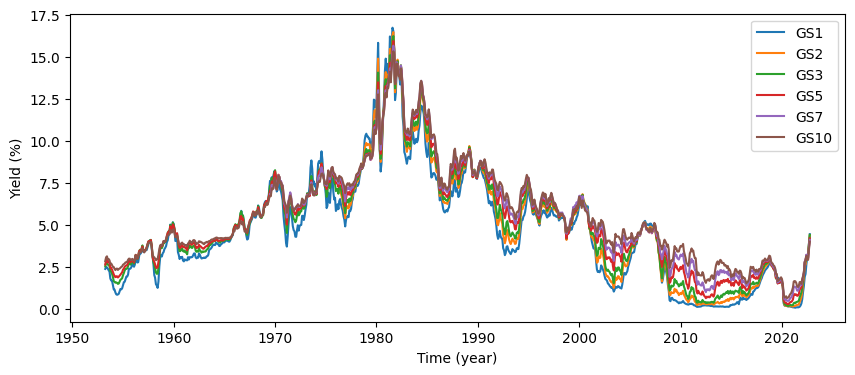

In [7]:
treasury_bills = get_all_series()

In [8]:
dx = merge_data_series(treasury_bills)
dx

,date,GS1,GS1_CHG,GS2,GS2_CHG,GS3,GS3_CHG,GS5,GS5_CHG,GS7,GS7_CHG,GS10,GS10_CHG
0,1953-04-01,2.36000,NaN,NaN,NaN,2.51000,NaN,2.62000,NaN,NaN,NaN,2.83000,NaN
1,1953-05-01,2.48000,0.05085,NaN,NaN,2.72000,0.08367,2.87000,0.09542,NaN,NaN,3.05000,0.07774
2,1953-06-01,2.45000,-0.01210,NaN,NaN,2.74000,0.00735,2.94000,0.02439,NaN,NaN,3.11000,0.01967
3,1953-07-01,2.38000,-0.02857,NaN,NaN,2.62000,-0.04380,2.75000,-0.06463,NaN,NaN,2.93000,-0.05788
4,1953-08-01,2.28000,-0.04202,NaN,NaN,2.58000,-0.01527,2.80000,0.01818,NaN,NaN,2.95000,0.00683
...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,2022-06-01,2.65000,0.28641,3.00000,0.14504,3.15000,0.12903,3.19000,0.11150,3.21000,0.09932,3.14000,0.08276
831,2022-07-01,3.02000,0.13962,3.04000,0.01333,3.03000,-0.03810,2.96000,-0.07210,2.97000,-0.07477,2.90000,-0.07643
832,2022-08-01,3.28000,0.08609,3.25000,0.06908,3.23000,0.06601,3.03000,0.02365,2.98000,0.00337,2.90000,0.00000
833,2022-09-01,3.89000,0.18598,3.86000,0.18769,3.88000,0.20124,3.70000,0.22112,3.64000,0.22148,3.52000,0.21379


In [9]:
features = [col for col in dx.columns if ("CHG" in col)]
features

['GS1_CHG', 'GS2_CHG', 'GS3_CHG', 'GS5_CHG', 'GS7_CHG', 'GS10_CHG']

In [10]:
dataset = dx[features]
dataset

,GS1_CHG,GS2_CHG,GS3_CHG,GS5_CHG,GS7_CHG,GS10_CHG
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.05085,NaN,0.08367,0.09542,NaN,0.07774
2,-0.01210,NaN,0.00735,0.02439,NaN,0.01967
3,-0.02857,NaN,-0.04380,-0.06463,NaN,-0.05788
4,-0.04202,NaN,-0.01527,0.01818,NaN,0.00683
...,...,...,...,...,...,...
830,0.28641,0.14504,0.12903,0.11150,0.09932,0.08276
831,0.13962,0.01333,-0.03810,-0.07210,-0.07477,-0.07643
832,0.08609,0.06908,0.06601,0.02365,0.00337,0.00000
833,0.18598,0.18769,0.20124,0.22112,0.22148,0.21379


### Data querying and retrieval is complete.

# End of Step 1.

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

# Step 2: Consider the dataset of monthly changes of the 6 series above. Can you reduce the dimensions of this new dataset, while still explaining “most” of the variation in it? How would you interpret these “reduced”dimensions? Are they stable over time?

In [11]:
## Standardize the dataset using sklearn pre processing libraries and transform data using an imputer.
def standardize_columns(data: pd.DataFrame, strategy: str) -> np.ndarray:
    """
        Plot the graph with the first two columns of dataframe as the axes.
        Saves an SVG image of the graph that is plotted.
        
        Updates the given dataframe by replacing the nan values with 0.
        Fits the data in the dataframe using StandardScaler from sklearn.
        
        Input: data, input DataFrame to be transformed using StandardScaler.
               strategy, the string input for strategy argument in SimpleImputer method.
        
        Output: standardized_data, a numpy array which consists of transformed
                                   values for all rows and columns.
    """
    ## Reason for imputing the nan values -> 
    ## we need the dataset to be free from nan values since the dimensionality reduction techniques are impacted by each value.
    if strategy == "median":
        data = SimpleImputer(missing_values = np.nan, strategy = "median").fit_transform(data)
    elif strategy == "constant": 
        ## Reason for filling nan with zeroes -> We use zero since these bonds have not yielded any returns.
        data = SimpleImputer(missing_values = np.nan, fill_value = 0).fit_transform(data)
    else:
        data = SimpleImputer(missing_values = np.nan, strategy = 'mean').fit_transform(data)
    standardized_data = StandardScaler().fit_transform(data)
    return standardized_data

In [12]:
## We prepare the data such that it is Standardized for Principal Component Analysis:
def dimensionality_reduction_function(features: list, data: pd.DataFrame, reduction_type: str):
    """
        Given a dataset with features - we perform Principal Component Analysis(PCA)/Truncated Singular Value 
        Decomposition (tSVD) to get reduced dimensions.
        
        Input: features, a list of the feature colums.
               data, a pandas dataframe of the dataset.
               reduction_type, a string representing PCA or tSVD for dimensionality reduction.
        Output: Perform PCA on imputed and standardized data to get reduced dimensions.
                Also, print relavant information while simulating the PCA dimensionality reduction.
                Returns model_df, which is has the data with reduced dimensions.
    """
    n_components = range(1, len(features)+1)
    main_model = None
    main_model_df = None
    print(f"{reduction_type} Simulation:")
    for n in n_components:
        if reduction_type.upper() == "PCA":
            model = PCA(n_components = n, random_state = 10)
            model_data = model.fit_transform(data)
            model_features = [f"Principal Component {x+1}" for x in range(len(model_data[0]))]
            model_df =  pd.DataFrame(model_data, columns = model_features)
            cols = ["date"] + list(model_df.columns)
            model_df["date"] = dx["date"]
            model_importance = model.explained_variance_ratio_
        elif reduction_type.upper() == "TSVD":
            model = TruncatedSVD(n_components = n, random_state = 20)
            model_data = model.fit_transform(data)
            model_features = [f"Feature {x+1}" for x in range(len(model_data[0]))]
            model_df =  pd.DataFrame(model_data, columns = model_features)
            model_df["date"] = dx["date"]
            cols = ["date"] + list(model_df.columns)
            model_importance = model.explained_variance_ratio_
        
        ## Print the simulation:
        print("--"*10)
        if n == len(features):            
            print(f"If we do not reduce the dimensions using {reduction_type}:") 
            print(f"Number of feature dimensions = {data.shape[1]}")
            print(f"Number of dimensions reduced = {6-n}")
            print(f"Number of feature dimensions after dimensionality reduction = {model_data.shape[1]}")
            print(f"Variance explained by the feature = {round(sum(model_importance) * 100, 2)}%")          
        else:            
            print(f"If we reduce the dimensions from 6 to {n} using {reduction_type}:") 
            print(f"Number of feature dimensions = {data.shape[1]}")
            print(f"Number of dimensions reduced = {6-n}")
            print(f"Number of feature dimensions after dimensionality reduction = {model_data.shape[1]}")
            print(f"Variance explained by the feature = {round(sum(model_importance) * 100, 2)}%")

        for i in range(len(model_importance)):
            print(f"{round(model_importance[i] * 100, 2)}% of variance is explained by Principal Component {i+1}")
        model_df = model_df[cols]
        if n == 2:
            main_model = model
            main_model_df = model_df
        model_df.to_csv(os.path.join(directory, f"{reduction_type}_DimensionsReduced_to_{n}.csv"), index = False)
    return model_df, model, main_model

#### Using PCA to reduce dimensions - we assume the data as sparse and run the model.

In [13]:
df_pca = standardize_columns(dataset.copy(), "median")
df_tsvd = standardize_columns(dataset.copy(), "constant")

In [14]:
pd.DataFrame(df_pca, columns = features)

,GS1_CHG,GS2_CHG,GS3_CHG,GS5_CHG,GS7_CHG,GS10_CHG
0,-0.05925,-0.04057,-0.02521,-0.03028,-0.06216,-0.03585
1,0.38043,-0.04057,0.86914,1.20253,-0.06216,1.36909
2,-0.16912,-0.04057,0.02714,0.27305,-0.06216,0.31968
3,-0.31296,-0.04057,-0.53721,-0.89181,-0.06216,-1.08185
4,-0.43035,-0.04057,-0.22244,0.19180,-0.06216,0.08751
...,...,...,...,...,...,...
830,2.43706,1.57787,1.36970,1.41293,1.58735,1.45982
831,1.15551,0.10821,-0.47432,-0.98962,-1.21144,-1.41720
832,0.68815,0.73026,0.67430,0.26334,0.04475,-0.03585
833,1.56021,2.05383,2.16639,2.84746,3.55140,3.82795


In [15]:
pca_result, pca_model, pca_all = dimensionality_reduction_function(features, df_pca, "PCA")

PCA Simulation:
--------------------
If we reduce the dimensions from 6 to 1 using PCA:
Number of feature dimensions = 6
Number of dimensions reduced = 5
Number of feature dimensions after dimensionality reduction = 1
Variance explained by the feature = 83.96%
83.96% of variance is explained by Principal Component 1
--------------------
If we reduce the dimensions from 6 to 2 using PCA:
Number of feature dimensions = 6
Number of dimensions reduced = 4
Number of feature dimensions after dimensionality reduction = 2
Variance explained by the feature = 94.21%
83.96% of variance is explained by Principal Component 1
10.25% of variance is explained by Principal Component 2
--------------------
If we reduce the dimensions from 6 to 3 using PCA:
Number of feature dimensions = 6
Number of dimensions reduced = 3
Number of feature dimensions after dimensionality reduction = 3
Variance explained by the feature = 97.61%
83.96% of variance is explained by Principal Component 1
10.25% of variance is

#### Results using PCA - with nan filled with median: We could ideally reduce the feature dimensions to 2 dimensions and still have data such that the features explain 94.20% of the variance.

#### Using tSVG to reduce dimensions - we assume the data as sparse and run the model.

In [16]:
pd.DataFrame(df_tsvd, columns = features)

,GS1_CHG,GS2_CHG,GS3_CHG,GS5_CHG,GS7_CHG,GS10_CHG
0,0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000
1,0.38036,0.00000,0.86911,1.20250,0.00000,1.36905
2,-0.16920,0.00000,0.02711,0.27301,0.00000,0.31964
3,-0.31303,0.00000,-0.53724,-0.89184,0.00000,-1.08190
4,-0.43042,0.00000,-0.22247,0.19177,0.00000,0.08747
...,...,...,...,...,...,...
830,2.43700,1.55815,1.36967,1.41290,1.56921,1.45977
831,1.15544,0.08788,-0.47435,-0.98965,-1.23124,-1.41724
832,0.68808,0.71019,0.67427,0.26331,0.02570,-0.03589
833,1.56014,2.03432,2.16636,2.84742,3.53443,3.82791


In [17]:
tsvd_result, tsvd_model, tsvd_all = dimensionality_reduction_function(features, df_tsvd, "tSVD")

tSVD Simulation:
--------------------
If we reduce the dimensions from 6 to 1 using tSVD:
Number of feature dimensions = 6
Number of dimensions reduced = 5
Number of feature dimensions after dimensionality reduction = 1
Variance explained by the feature = 84.0%
84.0% of variance is explained by Principal Component 1
--------------------
If we reduce the dimensions from 6 to 2 using tSVD:
Number of feature dimensions = 6
Number of dimensions reduced = 4
Number of feature dimensions after dimensionality reduction = 2
Variance explained by the feature = 94.25%
84.0% of variance is explained by Principal Component 1
10.25% of variance is explained by Principal Component 2
--------------------
If we reduce the dimensions from 6 to 3 using tSVD:
Number of feature dimensions = 6
Number of dimensions reduced = 3
Number of feature dimensions after dimensionality reduction = 3
Variance explained by the feature = 97.64%
84.0% of variance is explained by Principal Component 1
10.25% of variance is

#### Results using tSVD - with nan filled with zero: We could ideally reduce the feature dimensions to 2 dimensions and still have data such that the features explain 94.24% of the variance.

# End of Step 2.

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

## Visualizing the models

#### Visualization using a single dataframe on how the variance is being explained after PCA and tSVD methods are applied. I've printed the two slices such that the variance explained can be viewed properly.

#### We stop at n_components = 2 but to show the overall working of each model, however, here we make an observation on n_components = 6 (number of features). 

#### It shows how dimensionality reduction using PCA and tSVDA impacts the explained variance of the Principal Components.

In [18]:
## Given the sklearn model used to fit the dataset used for dimensionality reduction we extract the explained variance.
def visualize_reduction(model, features: list) -> (pd.DataFrame, pd.DataFrame):
    """
        Extract the variance explained metrics to visualize the model for both PCA and tSVD
        Input: model, the sklearn model either PCA or tSVD.
               features, the list of feature columns.
        Output: dffx, a dataframe:
            (1) the first principal component rows -> 2 since the variance explained is above 95% 
                threshold which is enough for reducing the dimensions down. 
            (2) The remaining four principal component rows.
    """
    n_pcs= model.components_.shape[0]

    dffx = pd.DataFrame(model.components_, columns = features)
    dffx["PC"] = dffx.index + 1

    most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]
    variances = [model.explained_variance_ratio_[i] * 100 for i in range(n_pcs)]
    dffx["Explained Variance Ratio"] = variances

    most_important_names = [features[most_important[i]] for i in range(n_pcs)]

    dffx["Cummulative Explained Variance"] = dffx["Explained Variance Ratio"].cumsum()
    dffx["Most important feature in Principal Component"] = most_important_names
    
    return dffx

In [19]:
## Utility function that helps in generating scree plots
def scree_plot(df: pd.DataFrame, name: str) -> None:
    """
        Generates a scree plot for visualizing the results of dimensionality reductions.
        Input:
            df, a dataframe which contains the principal components and cummulative variance explained by them.
            name, a string representing the model - either PCA or tSVD.
            
        Ouptut:
            Plots and saves the graph for visualizing the variance explained by principal components
            returns None (Void function)
    """
    plt.scatter(df["PC"], df["Cummulative Explained Variance"], c = 'r')
    plt.plot(df["PC"], df["Cummulative Explained Variance"])
    x_ticks = df["PC"].tolist()
    plt.xlabel("Principal Components")
    plt.ylabel("Percentage of Variance explained \nby the Principal Components")
    plt.xticks(x_ticks)
    plt.suptitle(f"{name}")
    plt.savefig(f"./Results/{name}.svg", dpi = 500)
    plt.show()

### PCA

In [20]:
v_pca = visualize_reduction(pca_model, features)
v_pca[:2]

,GS1_CHG,GS2_CHG,GS3_CHG,GS5_CHG,GS7_CHG,GS10_CHG,PC,Explained Variance Ratio,Cummulative Explained Variance,Most important feature in Principal Component
0,-0.34320,-0.40565,-0.43309,-0.43373,-0.41836,-0.40859,1,83.96162,83.96162,GS5_CHG
1,0.75230,0.29502,0.07560,-0.21693,-0.36239,-0.40362,2,10.24656,94.20818,GS1_CHG


In [21]:
v_pca[2:]

,GS1_CHG,GS2_CHG,GS3_CHG,GS5_CHG,GS7_CHG,GS10_CHG,PC,Explained Variance Ratio,Cummulative Explained Variance,Most important feature in Principal Component
2,0.52269,-0.70689,-0.17876,0.06593,-0.05043,0.43388,3,3.40285,97.61103,GS2_CHG
3,-0.14781,-0.33989,0.66012,0.41811,-0.45142,-0.21972,4,1.60968,99.22071,GS3_CHG
4,0.14215,-0.32971,0.02727,0.12537,0.66850,-0.63854,5,0.63335,99.85407,GS7_CHG
5,-0.03160,-0.15645,0.58161,-0.75494,0.20109,0.16089,6,0.14593,100.00000,GS5_CHG


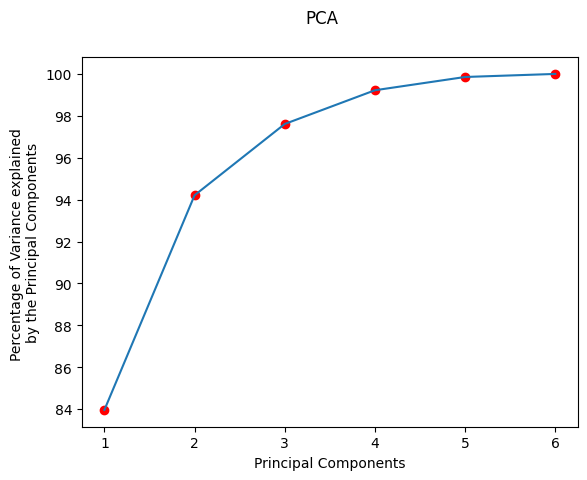

In [22]:
scree_plot(v_pca, "PCA")

### tSVD

In [23]:
v_tsvd = visualize_reduction(tsvd_model, features)
v_tsvd[:2]

,GS1_CHG,GS2_CHG,GS3_CHG,GS5_CHG,GS7_CHG,GS10_CHG,PC,Explained Variance Ratio,Cummulative Explained Variance,Most important feature in Principal Component
0,-0.34310,-0.40567,-0.43300,-0.43369,-0.41853,-0.40863,1,84.00022,84.00022,GS5_CHG
1,0.75251,0.29470,0.07580,-0.21675,-0.36242,-0.40349,2,10.24638,94.24661,GS1_CHG


In [24]:
v_tsvd[2:]

,GS1_CHG,GS2_CHG,GS3_CHG,GS5_CHG,GS7_CHG,GS10_CHG,PC,Explained Variance Ratio,Cummulative Explained Variance,Most important feature in Principal Component
2,0.52422,-0.70613,-0.18323,0.06292,-0.04333,0.43262,3,3.38873,97.63533,GS2_CHG
3,-0.14196,-0.35036,0.66018,0.41917,-0.44131,-0.22540,4,1.59679,99.23213,GS3_CHG
4,0.14171,-0.32039,0.01588,0.12211,0.67445,-0.63814,5,0.62239,99.85452,GS7_CHG
5,-0.03115,-0.15671,0.58061,-0.75523,0.20486,0.15821,6,0.14548,100.00000,GS5_CHG


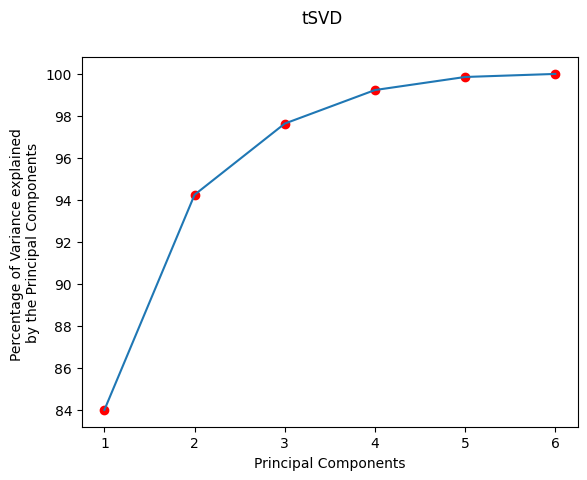

In [25]:
scree_plot(v_tsvd, "tSVD")

### Conclusions from visualization

#### Both PCA and tSVD reduce to 2 dimensions with similar percentage of variance explained results. tSVD is negligibly better than PCA.

#### Note that both PCA and tSVD explain around 94% of the variance using 2 Principal Components. In both cases the original feature contributing to majority of the variance explained is "GS5_CHG" and the second highest contribution is by the feature "GS1_CHG"